In [2]:
import numpy as np

def spline_cubico_sujeto(x, y, fp0, fpn):
    n = len(x) - 1
    h = np.diff(x)
    al = np.zeros(n + 1)

    # Condiciones de frontera
    al[0] = 3 * ((y[1] - y[0]) / h[0] - fp0)
    al[n] = 3 * (fpn - (y[n] - y[n-1]) / h[n-1])

    for i in range(1, n):
        al[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    # Construcción del sistema tridiagonal
    l = np.ones(n + 1)
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)
    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)

    l[0] = 2 * h[0]
    mu[0] = 0.5
    z[0] = al[0] / l[0]

    for i in range(1, n):
        l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * mu[i-1]
        mu[i] = h[i] / l[i]
        z[i] = (al[i] - h[i-1] * z[i-1]) / l[i]

    l[n] = h[n-1] * (2 - mu[n-1])
    z[n] = (al[n] - h[n-1] * z[n-1]) / l[n]

    c[n] = z[n]
    for j in reversed(range(n)):
        c[j] = z[j] - mu[j] * c[j+1]
        b[j] = (y[j+1] - y[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3 * h[j])

    a = y[:-1]
    return a, b, c[:-1], d


In [3]:
def spline_cubico_natural(x, y):
    n = len(x) - 1
    h = np.diff(x)
    al = np.zeros(n - 1)

    for i in range(1, n):
        al[i - 1] = (3/h[i]) * (y[i+1] - y[i]) - (3/h[i-1]) * (y[i] - y[i-1])

    # Matriz tridiagonal
    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)
    A = np.zeros((n - 1, n - 1))
    rhs = al.copy()

    for i in range(n - 1):
        A[i, i] = 2 * (h[i] + h[i+1])
        if i != 0:
            A[i, i-1] = h[i]
        if i != n - 2:
            A[i, i+1] = h[i+1]

    # Resolver el sistema A * c = al
    c = np.zeros(n + 1)
    if n > 1:
        c[1:n] = np.linalg.solve(A, rhs)

    # Calcular coeficientes b, d, a
    b = np.zeros(n)
    d = np.zeros(n)
    a = y[:-1]

    for i in range(n):
        b[i] = (y[i+1] - y[i])/h[i] - h[i]*(2*c[i] + c[i+1])/3
        d[i] = (c[i+1] - c[i]) / (3*h[i])

    return a, b, c[:-1], d


In [4]:
def spline_cubico_extrapolado(x, y):
    n = len(x) - 1
    h = np.diff(x)
    al = np.zeros(n + 1)

    # Rellenar el vector del sistema
    for i in range(1, n):
        al[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    # Construir sistema tridiagonal
    l = np.ones(n + 1)
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)

    A = np.zeros((n + 1, n + 1))
    rhs = al.copy()

    # Extrapolación lineal: imponemos c_0 = c_1 y c_{n-1} = c_n
    A[0, 0] = h[1]
    A[0, 1] = -(h[0] + h[1])
    A[0, 2] = h[0]

    A[n, n-2] = h[n-1]
    A[n, n-1] = -(h[n-2] + h[n-1])
    A[n, n] = h[n-2]

    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]

    # Resolver
    c = np.linalg.solve(A, rhs)

    # Coeficientes
    b = np.zeros(n)
    d = np.zeros(n)
    a = y[:-1]

    for i in range(n):
        b[i] = (y[i+1] - y[i]) / h[i] - h[i] * (2*c[i] + c[i+1]) / 3
        d[i] = (c[i+1] - c[i]) / (3*h[i])

    return a, b, c[:-1], d


In [5]:
def spline_cubico_terminacion_parabolica(x, y):
    n = len(x) - 1
    h = np.diff(x)
    al = np.zeros(n + 1)

    # Cálculo del vector del sistema
    for i in range(1, n):
        al[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    # Construir sistema con condiciones parabólicas
    A = np.zeros((n + 1, n + 1))
    rhs = al.copy()

    # c0 = c1  ⇒ c0 - c1 = 0
    A[0, 0] = 1
    A[0, 1] = -1
    rhs[0] = 0

    # Interior
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]

    # cn = cn-1  ⇒ cn - cn-1 = 0
    A[n, n] = 1
    A[n, n-1] = -1
    rhs[n] = 0

    # Resolver el sistema
    c = np.linalg.solve(A, rhs)

    # Calcular coeficientes a, b, d
    b = np.zeros(n)
    d = np.zeros(n)
    a = y[:-1]

    for i in range(n):
        b[i] = (y[i+1] - y[i]) / h[i] - h[i] * (2*c[i] + c[i+1]) / 3
        d[i] = (c[i+1] - c[i]) / (3*h[i])

    return a, b, c[:-1], d


In [8]:
def spline_cubico_curvatura(x, y, curv0, curvn):
    n = len(x) - 1
    h = np.diff(x)
    al = np.zeros(n + 1)

    for i in range(1, n):
        al[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    A = np.zeros((n + 1, n + 1))
    rhs = al.copy()

    # Impone S''(x_0) = curv0
    A[0, 0] = 1
    rhs[0] = curv0

    # Interior
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i]   = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]

    # Impone S''(x_n) = curvn
    A[n, n] = 1
    rhs[n] = curvn

    # Resolver el sistema
    c = np.linalg.solve(A, rhs)

    # Calcular coeficientes
    a = y[:-1]
    b = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i+1] - y[i]) / h[i] - h[i] * (2*c[i] + c[i+1]) / 3
        d[i] = (c[i+1] - c[i]) / (3*h[i])

    return a, b, c[:-1], d


In [11]:
def evaluar_spline(x_eval, x, a, b, c, d):
    y_eval = np.zeros_like(x_eval)
    for i in range(len(x) - 1):
        mask = (x_eval >= x[i]) & (x_eval <= x[i+1])
        dx = x_eval[mask] - x[i]
        y_eval[mask] = a[i] + b[i]*dx + c[i]*dx**2 + d[i]*dx**3
    return y_eval


def imprimir_ecuaciones_spline(x, a, b, c, d, nombre="Spline", decimales=4):
    formato = f"{{:.{decimales}f}}"
    
    print(f"\nEcuaciones del spline para: {nombre}")
    for i in range(len(a)):
        xi = x[i]

        # Coeficientes desarrollados de (x - xi)^n
        A = d[i]
        B = 3 * d[i] * (-xi) + c[i]
        C = 3 * d[i] * xi**2 - 2 * c[i] * xi + b[i]
        D = a[i] + d[i] * (-xi)**3 + c[i] * xi**2 - b[i] * xi

        print(f"Tramo [{formato.format(x[i])}, {formato.format(x[i+1])}]:")
        print(f"Forma con desplazamiento:")
        print(f"S_{i}(x) = {formato.format(a[i])} + {formato.format(b[i])}(x - {formato.format(xi)}) + "
              f"{formato.format(c[i])}(x - {formato.format(xi)})^2 + {formato.format(d[i])}(x - {formato.format(xi)})^3")
        print(f"Forma expandida:")
        print(f"S_{i}(x) = {formato.format(A)}x^3 + {formato.format(B)}x^2 + {formato.format(C)}x + {formato.format(D)}")
        print("-" * 60)



Ecuaciones del spline para: Natural
Tramo [0.0000, 1.0000]:
Forma con desplazamiento:
S_0(x) = 0.0000 + 1.6667(x - 0.0000) + 0.0000(x - 0.0000)^2 + -0.6667(x - 0.0000)^3
Forma expandida:
S_0(x) = -0.6667x^3 + 0.0000x^2 + 1.6667x + 0.0000
------------------------------------------------------------
Tramo [1.0000, 2.0000]:
Forma con desplazamiento:
S_1(x) = 1.0000 + -0.3333(x - 1.0000) + -2.0000(x - 1.0000)^2 + 1.3333(x - 1.0000)^3
Forma expandida:
S_1(x) = 1.3333x^3 + -6.0000x^2 + 7.6667x + -2.0000
------------------------------------------------------------
Tramo [2.0000, 3.0000]:
Forma con desplazamiento:
S_2(x) = 0.0000 + -0.3333(x - 2.0000) + 2.0000(x - 2.0000)^2 + -0.6667(x - 2.0000)^3
Forma expandida:
S_2(x) = -0.6667x^3 + 6.0000x^2 + -16.3333x + 14.0000
------------------------------------------------------------

Ecuaciones del spline para: Sujeto
Tramo [0.0000, 1.0000]:
Forma con desplazamiento:
S_0(x) = 0.0000 + 1.0000(x - 0.0000) + 1.2000(x - 0.0000)^2 + -1.2000(x - 0.0000)^

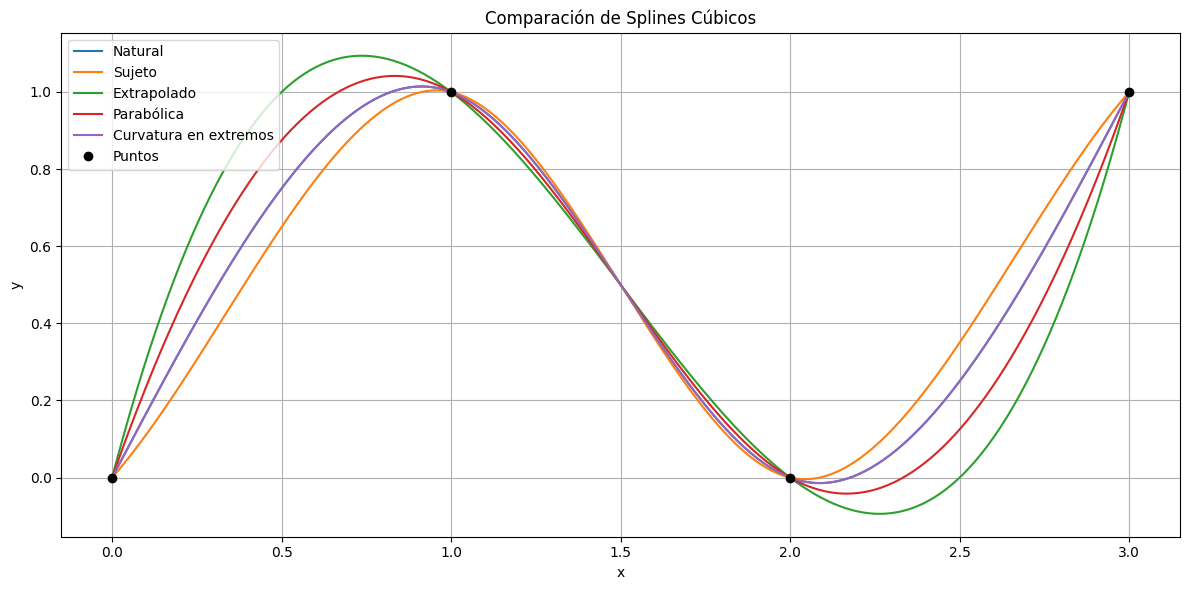

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos los puntos
x = np.array([0.0, 1.0, 2.0, 3.0])
y = np.array([0.0, 1.0, 0.0, 1.0])
x_eval = np.linspace(x[0], x[-1], 500)

# Requiere tus funciones previamente definidas:
# spline_cubico_natural, spline_cubico_sujeto, spline_cubico_extrapolado, spline_cubico_terminacion_parabolica, spline_cubico_curvatura
# + evaluar_spline

splines = {
    "Natural": spline_cubico_natural(x, y),
    "Sujeto": spline_cubico_sujeto(x, y, fp0=1.0, fpn=1.0),
    "Extrapolado": spline_cubico_extrapolado(x, y),
    "Parabólica": spline_cubico_terminacion_parabolica(x, y),
    "Curvatura en extremos": spline_cubico_curvatura(x, y, curv0=0.0, curvn=0.0)
}

# Graficar
plt.figure(figsize=(12, 6))
for nombre, (a, b, c, d) in splines.items():
    y_eval = evaluar_spline(x_eval, x, a, b, c, d)
    imprimir_ecuaciones_spline(x, a, b, c, d, nombre)
    plt.plot(x_eval, y_eval, label=nombre)

plt.plot(x, y, 'ko', label="Puntos")
plt.title("Comparación de Splines Cúbicos")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
